In [1]:
from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample

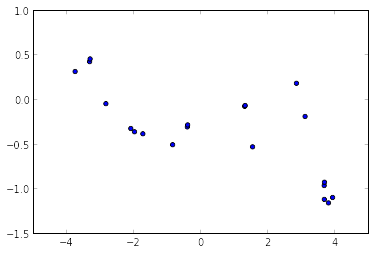

In [61]:
# sample x points 
X = (np.random.rand(50)*8-4).reshape((-1, 1))
# sample a function
cov = GPCov(wfn_params=[1.0], wfn_str="se", dfn_params=[1.0], dfn_str="euclidean")
noise_var=0.01
f = prior_sample(X, cov, noise_var)

n = len(X)
ntrain = 20
p1 = np.array(sorted(np.arange(ntrain), key=lambda i: X[i]), dtype=int)
X1= X[p1]
f1 = f[p1]

p2 = np.array(sorted(np.arange(ntrain, n), key=lambda i: X[i]), dtype=int)
X2= X[p2]
f2 = f[p2]

scatter(X1, f1)
#scatter(X2, f2, c="red")

In [62]:
import scipy.stats
def analyze_pred(means, vs):
    se = (means-f2)**2
    baseline = np.sqrt(np.sum((np.mean(f2)-f2)**2))
    smse = np.sqrt(np.sum(se)) / baseline
    #print "baseline SE", baseline, "GP", np.sqrt(np.sum(se))
    
    ll = np.sum([scipy.stats.norm(loc=mean, scale = np.sqrt(v)).logpdf(f) for (mean, v, f) in zip(means, vs, f2)])
    baseline = np.sum(scipy.stats.norm(loc=np.mean(f2), scale = np.std(f2)).logpdf(f2))
    msll = (ll-baseline)/len(means)
    #print "baseline ll", baseline/len(means), "GP", ll/len(means)
    return smse, msll

In [63]:
X1 = X1.reshape((-1, 1))

# Full GP

0.328193170194 1.03648022973


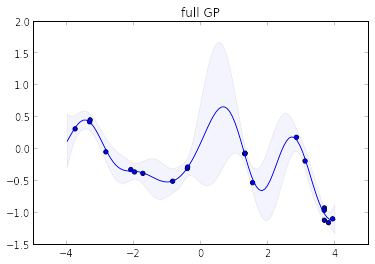

In [64]:

fgp = GP(X=X1, y=f1, cov_main=cov, noise_var=0.01)
xs = np.linspace(-4, 4, 100)
fs = [fgp.predict(x.reshape((-1, 1))) for x in xs]
vs = [float(fgp.variance(x.reshape((-1, 1)))) for x in xs]

scatter(X1, f1)
plot(xs, fs, c="blue")
fill_between(xs, fs, fs+2*np.sqrt(vs), facecolor='blue', alpha=0.2)
fill_between(xs, fs, fs-2*np.sqrt(vs), facecolor='blue', alpha=0.2)
title("full GP")

fs_pred = [fgp.predict(x.reshape((-1, 1))) for x in X2]
vs_pred = [float(fgp.variance(x.reshape((-1, 1)))) for x in X2]
smse, msll = analyze_pred(fs_pred, vs_pred)
print smse, msll

# Independent-Function local GPs

0.308483902961 0.953096051227


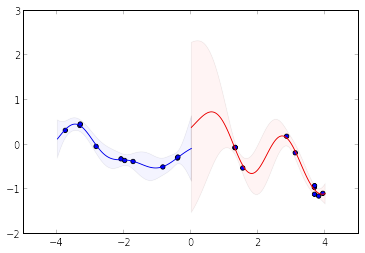

In [65]:
thresh = 0.0
mask = (X1 < thresh).flatten()
X1m1 = X1[mask].reshape((-1, 1))
f1m1 = f1[mask]

X1m2 = X1[~mask].reshape((-1, 1))
f1m2 = f1[~mask]

lgp1 = GP(X=X1m1, y=f1m1, cov_main=cov, noise_var=0.01)
lgp2 = GP(X=X1m2, y=f1m2, cov_main=cov, noise_var=0.01)
xs = np.linspace(-4, thresh, 100)
fs = [lgp1.predict(x.reshape((-1, 1))) for x in xs]
vs = [float(lgp1.variance(x.reshape((-1, 1)))) for x in xs]
fill_between(xs, fs, fs+2*np.sqrt(vs), facecolor='blue', alpha=0.2)
fill_between(xs, fs, fs-2*np.sqrt(vs), facecolor='blue', alpha=0.2)
plot(xs, fs, c="blue")

xs = np.linspace(thresh, 4, 100)
fs = [lgp2.predict(x.reshape((-1, 1))) for x in xs]
vs = [float(lgp2.variance(x.reshape((-1, 1)))) for x in xs]

plot(xs, fs, c="red")
fill_between(xs, fs, fs+2*np.sqrt(vs), facecolor='red', alpha=0.2)
fill_between(xs, fs, fs-2*np.sqrt(vs), facecolor='red', alpha=0.2)
scatter(X1, f1)


fs_pred = [(lgp1 if x<thresh else lgp2).predict(x.reshape((-1, 1))) for x in X2]
vs_pred = [float((lgp1 if x<thresh else lgp2).variance(x.reshape((-1, 1)))) for x in X2]


smse, msll = analyze_pred(fs_pred, vs_pred)
print smse, msll

# Independent-Training local GPs

[[ 0.95608438]]
[[ 0.05391562]]
[ 5.73763671  4.05174121  3.45523071  2.96521859  2.41666689  1.18782329
  0.5896392   0.40206609  0.12176502  0.08938807  0.06585545  0.03019634
  0.01693713  0.00916218  0.01060089  0.01004377  0.0100226   0.0100052
  0.01000066  0.01        0.01      ]


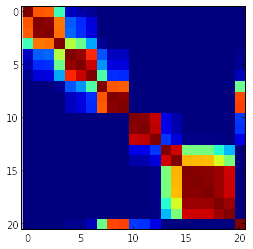

In [66]:
Ktrain = mcov(X1, cov, noise_var)
xpred = np.array((0.0,)).reshape(-1, 1)
KZtrain = mcov(xpred, cov, noise_var, X1)

boundary = np.max(np.arange(X1.shape[0])[mask])+1

Ktrain_cropped = Ktrain.copy()
Ktrain_cropped[boundary:, :boundary] = 0
Ktrain_cropped[:boundary, boundary:] = 0


KZ = mcov(xpred, cov, noise_var)
KYinv = np.linalg.inv(Ktrain_cropped)
qf = np.dot(KZtrain, np.dot(KYinv, KZtrain.T))


n = Ktrain_cropped.shape[0]
fullK = np.zeros((n+1, n+1))
fullK[:n,:n] = Ktrain_cropped
fullK[n, :n] = KZtrain.flatten()
fullK[:n, n] = KZtrain.flatten()
fullK[n, n] = KZ
figure()
imshow(fullK, interpolation="none")

print qf
print KZ-qf
print np.linalg.eig(fullK)[0]

# Bayesian Committee Machine

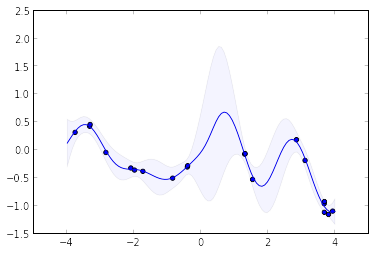

In [70]:
xs = np.linspace(-4, 4, 100)
fs1 = np.array([lgp1.predict(x.reshape((-1, 1))) for x in xs])
vs1 = np.array([float(lgp1.variance(x.reshape((-1, 1)))) for x in xs])

fs2 = np.array([lgp2.predict(x.reshape((-1, 1))) for x in xs])
vs2 = np.array([float(lgp2.variance(x.reshape((-1, 1)))) for x in xs])

prior_var = cov.wfn_params[0]
vs_full = [1.0/(1/v1 + 1/v2 - 1.0/prior_var) for (v1, v2) in zip(vs1, vs2)]
fs_full = [v * (m1/v1 + m2/v2) for (v, v1, v2, m1, m2) in zip(vs_full, vs1, vs2, fs1, fs2)]

plot(xs, fs_full, c="blue")
fill_between(xs, fs_full, fs_full+2*np.sqrt(vs_full), facecolor='blue', alpha=0.2)
fill_between(xs, fs_full, fs_full-2*np.sqrt(vs_full), facecolor='blue', alpha=0.2)

scatter(X1, f1)


# Belief Propagation

(10, 1)
(10, 10)
(20,)
(10,)
[[ 1.01]]
[[  7.03806881e-07   1.53152124e-05   1.67816898e-05   3.07222872e-04
    1.21691802e-02   1.90972751e-02   4.84787716e-02   4.85087698e-01
    8.43836709e-01   8.50998746e-01]]
[  30.73508745  147.73881647  -61.55143234    1.54826298  -68.16598006
   11.98669691  -53.63883291  -43.74479658 -207.27151727  144.53846422]
(array([-76.32055461]), array([[-167.50417493]]))


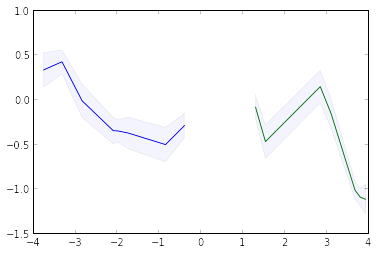

In [87]:
X1m1 = X1[mask].reshape((-1, 1))
f1m1 = f1[mask]

X1m2 = X1[~mask].reshape((-1, 1))
f1m2 = f1[~mask]

K1 = mcov(X1m1, cov, noise_var)
K2 = mcov(X1m2, cov, noise_var)
K12 = mcov(X1m1, cov, noise_var, X2 = X1m2)


print X1m1.shape
K2inv = np.linalg.inv(K2)
K1inv = np.linalg.inv(K1)

print K1inv.shape
print f1.shape

f1_posterior_mean = fgp.predict(X1m1) 
f1_posterior_cov = fgp.covariance(X1m1, include_obs=False) 

f2_posterior_mean = fgp.predict(X1m2) 
f2_posterior_cov = fgp.covariance(X1m2, include_obs=False) 

plot(X1m1.flatten(), f1_posterior_mean)
plot(X1m2.flatten(), f2_posterior_mean)

vs1 = np.diag(f1_posterior_cov)
vs2 = np.diag(f2_posterior_cov)
print vs1.shape

fill_between(X1m1.flatten(), f1_posterior_mean, f1_posterior_mean+2*np.sqrt(vs1), facecolor='blue', alpha=0.2)
fill_between(X1m1.flatten(), f1_posterior_mean, f1_posterior_mean-2*np.sqrt(vs1), facecolor='blue', alpha=0.2)

fill_between(X1m2.flatten(), f2_posterior_mean, f2_posterior_mean+2*np.sqrt(vs2), facecolor='blue', alpha=0.2)
fill_between(X1m2.flatten(), f2_posterior_mean, f2_posterior_mean-2*np.sqrt(vs2), facecolor='blue', alpha=0.2)


def pred_test(x, trainX, trainPrec, trainMean):
    prior_v = mcov(x, cov, noise_var)
    print prior_v

    k = mcov(x, cov, noise_var, X2 = trainX)
    print k
    print np.dot(trainPrec, trainMean)
    m = np.dot(k, np.dot(trainPrec, trainMean))
    v = prior_v - np.dot(k, np.dot(trainPrec, k.T))
    return m, v

print pred_test(np.zeros((1,1)), X1m1, np.linalg.inv(f1_posterior_cov), f1_posterior_mean)


In [69]:
# can precompute covariances and conditional covariances. will need a predict tree
# finally I'll have means and covs for beliefs at f1 and f2. then how to predict?
# a) how does this work even for a single GP? if I have a belief about f1 that is 
#   not just the natural posterior covariance from the Gaussian prior, how do I use
#   this to predict?
# b) how do I combine predictions? does this model formally involve averaging predictions
#    from f1 and f2, no matter where I predict? if so it saves train time but *not* really
#    test time. 
# one way to interrogate this would be to do the variational derivation for f1,f2,f3 where f3 is
# a set of test points. this would implicitly make predictions at those points. I expect it would
# be a Bayesian combination of predictions from f1,f2, i.e. mean predictions weighted by precisions. 
# note in this case it would be prediction under the standard prior covariances, i.e. we'd ignore the 
# posterior issues, I think. 
# 
# I think I've just invented the Bayesian committee machine? 
# but I'm not clear on whether what I've done is necessarily transductive. 
# It seems like we should be able to come to a belief about f1, f2, then use these to predict anywhere we like. 
# 
#
